In [1]:
import json

import requests
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import geopandas as gpd
from shapely import geometry as sgeom
import rasterio as rio
import xarray as xr
from affine import Affine
from scipy import ndimage

How to change workflow:
* one function to create x array with slope and aspect elev, lc as a single xarray
* second function insret the dem to calculate the Hs to SWE 
* dask to speed up the Hs to SWE process 

In [2]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA')
domain = 'WY'

In [3]:
#CSO data path
CSOpath = 'cso-data.geojson'
#assimilation files 
assimPath = '/nfs/attic/dfh/Aragon2/CSOassim/'+domain+'/'

gdf = gpd.read_file('/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/CSO_SNOTEL_sites.geojson')

#path to CSO domain
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
    
#start date    
st = domains[domain]['st']
#end date
ed = domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# CSO projection
stn_proj = domains[domain]['stn_proj']

# CSO projection
mod_proj = domains[domain]['mod_proj']

## get CSO data

In [4]:
#edit time period 
#dates
st = '2018-09-01'
ed = '2019-09-30'

In [5]:
#Issue CSO API observations request and load the results into a GeoDataFrame
params = {
  "bbox": f"{Bbox['lonmin']},{Bbox['latmax']},{Bbox['lonmax']},{Bbox['latmin']}",
  "start_date": st,
  "end_date": ed,
  "format": "geojson",
  "limit": 5000,
}

csodata_resp = requests.get("https://api.communitysnowobs.org/observations", params=params)
csodatajson = csodata_resp.json()

In [6]:
CSO_gdf = gpd.GeoDataFrame.from_features(csodatajson, crs=stn_proj)

CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation
0,POINT (-110.96955 43.50077),YvtYk5nZ,Grant Henarie,47.0,SnowPilot,2020-12-15T22:00:00.000Z,2583.323730
1,POINT (-110.95316 43.49560),RHFMtCB0,Lynne Wolfe,89.0,SnowPilot,2020-12-15T20:00:00.000Z,2541.762939
2,POINT (-110.83179 43.62928),vPeIuJm1,Nancy Bockino,90.0,SnowPilot,2020-12-15T19:00:00.000Z,2400.353760
3,POINT (-110.87692 43.58721),4bMDgkOw,Dan Corn,115.0,SnowPilot,2020-12-15T16:50:00.000Z,2964.886963
4,POINT (-110.87884 43.58034),N1WOeAD3,Tim Petrick,150.0,SnowPilot,2020-12-14T17:00:00.000Z,2878.567627
...,...,...,...,...,...,...,...
627,POINT (-110.94512 43.50662),ZieRtWwG,Mike Hardaker,220.0,SnowPilot,2017-01-09T03:46:30.000Z,2681.205078
628,POINT (-110.15553 44.46178),ZsTR7G2t,John McCurdy,165.0,SnowPilot,2016-12-23T17:46:29.000Z,2770.274658
629,POINT (-110.87574 43.57965),Fqnv6kiF,Bill Anderson,142.0,SnowPilot,2016-12-21T13:28:18.000Z,2823.013916
630,POINT (-110.87301 43.59553),t0HyUg9o,Mike Rheam,32.0,SnowPilot,2016-12-02T22:20:07.000Z,2997.033203


In [7]:
#############################################################
ingdf = CSO_gdf

In [8]:
# projection
mod_proj = domains[domain]['mod_proj']
new=ingdf.to_crs(mod_proj)
new

,geometry,id,author,depth,source,timestamp,elevation
0,POINT (502461.436 4816427.679),YvtYk5nZ,Grant Henarie,47.0,SnowPilot,2020-12-15T22:00:00.000Z,2583.323730
1,POINT (503787.104 4815853.791),RHFMtCB0,Lynne Wolfe,89.0,SnowPilot,2020-12-15T20:00:00.000Z,2541.762939
2,POINT (513569.371 4830713.204),vPeIuJm1,Nancy Bockino,90.0,SnowPilot,2020-12-15T19:00:00.000Z,2400.353760
3,POINT (509935.987 4826034.074),4bMDgkOw,Dan Corn,115.0,SnowPilot,2020-12-15T16:50:00.000Z,2964.886963
4,POINT (509781.779 4825270.866),N1WOeAD3,Tim Petrick,150.0,SnowPilot,2020-12-14T17:00:00.000Z,2878.567627
...,...,...,...,...,...,...,...
627,POINT (504436.575 4817078.160),ZieRtWwG,Mike Hardaker,220.0,SnowPilot,2017-01-09T03:46:30.000Z,2681.205078
628,POINT (567177.357 4923510.576),ZsTR7G2t,John McCurdy,165.0,SnowPilot,2016-12-23T17:46:29.000Z,2770.274658
629,POINT (510032.501 4825195.160),Fqnv6kiF,Bill Anderson,142.0,SnowPilot,2016-12-21T13:28:18.000Z,2823.013916
630,POINT (510249.817 4826958.788),t0HyUg9o,Mike Rheam,32.0,SnowPilot,2016-12-02T22:20:07.000Z,2997.033203


# DEM

487200.0 4690100.0 625400.0 4937700.0


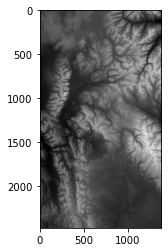

In [9]:
# dem path
dem_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_'+domain+'.tif'
# DEM data
src = rio.open(dem_path)
bound = src.bounds
minx = bound[0]
miny = bound[1]
maxx = bound[2]
maxy = bound[3]

#with rio.open(dtm) as src:
elevation = src.read(1)

print(minx,miny,maxx,maxy)
#plot
x = plt.imshow(src.read(1), cmap='gray')
plt.show()

In [10]:
new=ingdf.to_crs(mod_proj)
new.head()

,geometry,id,author,depth,source,timestamp,elevation
0,POINT (502461.436 4816427.679),YvtYk5nZ,Grant Henarie,47.0,SnowPilot,2020-12-15T22:00:00.000Z,2583.323730
1,POINT (503787.104 4815853.791),RHFMtCB0,Lynne Wolfe,89.0,SnowPilot,2020-12-15T20:00:00.000Z,2541.762939
2,POINT (513569.371 4830713.204),vPeIuJm1,Nancy Bockino,90.0,SnowPilot,2020-12-15T19:00:00.000Z,2400.353760
3,POINT (509935.987 4826034.074),4bMDgkOw,Dan Corn,115.0,SnowPilot,2020-12-15T16:50:00.000Z,2964.886963
4,POINT (509781.779 4825270.866),N1WOeAD3,Tim Petrick,150.0,SnowPilot,2020-12-14T17:00:00.000Z,2878.567627


In [11]:
#add x y values to CSO gdf
ingdf['x']=new.geometry.x
ingdf['y']=new.geometry.y

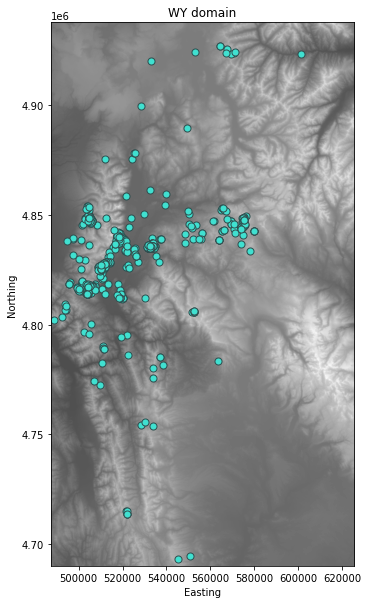

In [12]:
# plot georeferenced SnowModel output with SNOTEL stations 
fig, ax = plt.subplots(1,figsize=(8,10))

#hillshade and elevation
#ax.imshow(np.flipud(hillshade), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray')
ax.imshow(np.flipud(elevation), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray', alpha = 0.7)

ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

# title
plt.title(domain+' domain')

#stations
new.plot(ax=ax,markersize=50, color='turquoise', edgecolor = 'darkslategrey')

#leg = ax.get_legend()
#leg.set_bbox_to_anchor((1,1))


#plt.savefig(f"/nfs/attic/dfh/Aragon2/Notebooks/calibration_python/figs/test.png")#Python_Animation_02_frame_{i:04}.png")
plt.show()

In [13]:
#build list of coordinates from point geodataframe
xy = list(map(list, zip(new.geometry.x,new.geometry.y)))

In [14]:
#sample dem
with rio.open(dem_path) as src:
    ingdf['dem_elev'] = [sample[0] for sample in src.sample(xy)]

# Slope

In [15]:
import richdem as rd
from osgeo import gdal
ds = gdal.Open(dem_path)
data = np.array(ds.GetRasterBand(1).ReadAsArray())
rda = rd.rdarray(data, no_data=-9999)
slope = rd.TerrainAttribute(rda, attrib='slope_riserun')
#rd.rdShow(slope, axes=False, cmap='plasma', figsize=(8,10))

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


In [16]:
with rio.open(dem_path) as src:
    rows, cols = rio.transform.rowcol(src.transform, new.geometry.centroid.x, new.geometry.centroid.y)
ingdf['slope'] = slope[rows,cols]

# Aspect

In [17]:
rda = rd.rdarray(data, no_data=-9999)
aspect = rd.TerrainAttribute(rda, attrib='aspect')
#rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8,10))

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


In [18]:
#0=N, 1=NE, 2=E, 3=SE, 4=S, 5=SW, 6=W, 7=NW, 8=flat
DIR=aspect
DIR[(DIR>=0) & (DIR<=22.5)]=0
DIR[(DIR>22.5) & (DIR<=67.5)]=1
DIR[(DIR>67.5) & (DIR<=112.5)]=2
DIR[(DIR>112.5) & (DIR<=157.5)]=3
DIR[(DIR>157.5) & (DIR<=202.5)]=4
DIR[(DIR>202.5) & (DIR<=247.5)]=5
DIR[(DIR>247.5) & (DIR<=292.5)]=6
DIR[(DIR>292.5) & (DIR<=337.5)]=7
DIR[(DIR>337.5) & (DIR<=360)]=0
DIR[slope < 0.5]=8
DIR.astype(int)

ingdf['aspect'] = DIR[rows,cols]

# Landcover

### Snowmodel LC Codes

|Code  |Landcover Class |Code  |Landcover Class |
| --- | --- | --- | --- |
|1     | coniferous forest |13    | subalpine meadow  |      
|2     | deciduous forest |14    | tundra (non-tussock) |      
|3     | mixed forest |15    | tundra (tussock) |           
|4     | scattered short-conifer |16    | prostrate shrub tundra | 
|5     | clearcut conifer |17    | arctic gram. wetland |       
|6     | mesic upland shrub |18    | bare |       
|7     | xeric upland shrub |19    | water/possibly frozen |       
|8     | playa shrubland |20    | permanent snow/glacier |         
|9     | shrub wetland/riparian |21    | residential/urban |   
|10    | erect shrub tundra |22    | tall crops |       
|11    | low shrub tundra |23    | short crops |        
|12    | grassland rangeland  |24    | ocean |    
      

In [19]:
# nlcd path
lc_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/NLCD2016_'+domain+'.tif'


# DEM data
src = rio.open(lc_path)
bound = src.bounds
minx = bound[0]
miny = bound[1]
maxx = bound[2]
maxy = bound[3]

#with rio.open(dtm) as src:
lc = src.read(1)

# #reassign lc from NLCD to SM classes
DIR=DIR=np.empty([np.shape(lc)[0],np.shape(lc)[1]])
DIR[lc == 11 ]=24
DIR[lc == 12 ]=20
DIR[lc == 21 ]=21
DIR[lc == 22 ]=21
DIR[lc == 23 ]=21
DIR[lc == 24 ]=21
DIR[lc == 31 ]=18
DIR[lc == 41 ]=2
DIR[lc == 42 ]=1
DIR[lc == 43 ]=6
DIR[lc == 51 ]=6
DIR[lc == 52 ]=6
DIR[lc == 71 ]=12
DIR[lc == 72 ]=12
DIR[lc == 73 ]=12
DIR[lc == 74 ]=12
DIR[lc == 81 ]=23
DIR[lc == 82 ]=22
DIR[lc == 90 ]=9
DIR[lc == 95 ]=9
DIR.astype(int)

#sample lc
ingdf['lc'] = DIR[rows,cols]

# terrain complexity 

In [20]:
# terrain complexity 
tc = ndimage.generic_filter(elevation, np.std, size=3)
ingdf['tc'] = tc[rows,cols]

In [21]:
#ingdf.to_file(assimPath+"SNOTEL_attributes.json", driver="GeoJSON")

In [22]:
ingdf['dt'] = pd.to_datetime(ingdf['timestamp'], format='%Y-%m-%dT%H:%M:%S')
ingdf['dt'] = pd.to_datetime(ingdf['dt']).dt.date
#CSO_gdf.sort_values(by='dt') 

In [23]:
ingdf['Y'] = pd.DatetimeIndex(ingdf['dt']).year
ingdf['M'] = pd.DatetimeIndex(ingdf['dt']).month
ingdf['D'] = pd.DatetimeIndex(ingdf['dt']).day
ingdf["LON"] = ingdf.geometry.x
ingdf["LAT"] = ingdf.geometry.y
#convert snow depth to mm to input into density function
ingdf['H'] = ingdf.depth*10
ingdf.head()

,geometry,id,author,depth,source,timestamp,elevation,x,y,dem_elev,...,aspect,lc,tc,dt,Y,M,D,LON,LAT,H
0,POINT (-110.96955 43.50077),YvtYk5nZ,Grant Henarie,47.0,SnowPilot,2020-12-15T22:00:00.000Z,2583.323730,502461.435849,4.816428e+06,2453,...,4.0,1.0,14,2020-12-15,2020,12,15,-110.969553,43.500773,470.0
1,POINT (-110.95316 43.49560),RHFMtCB0,Lynne Wolfe,89.0,SnowPilot,2020-12-15T20:00:00.000Z,2541.762939,503787.104157,4.815854e+06,2590,...,1.0,1.0,38,2020-12-15,2020,12,15,-110.953159,43.495600,890.0
2,POINT (-110.83179 43.62928),vPeIuJm1,Nancy Bockino,90.0,SnowPilot,2020-12-15T19:00:00.000Z,2400.353760,513569.371488,4.830713e+06,2858,...,1.0,6.0,39,2020-12-15,2020,12,15,-110.831795,43.629283,900.0
3,POINT (-110.87692 43.58721),4bMDgkOw,Dan Corn,115.0,SnowPilot,2020-12-15T16:50:00.000Z,2964.886963,509935.987159,4.826034e+06,2928,...,1.0,1.0,15,2020-12-15,2020,12,15,-110.876920,43.587209,1150.0
4,POINT (-110.87884 43.58034),N1WOeAD3,Tim Petrick,150.0,SnowPilot,2020-12-14T17:00:00.000Z,2878.567627,509781.778997,4.825271e+06,2993,...,3.0,6.0,19,2020-12-14,2020,12,14,-110.878844,43.580339,1500.0


In [24]:
print('Total number of CSO in daimain = ',len(ingdf))

Total number of CSO in daimain =  632


In [25]:
mask = (ingdf['timestamp'] >= '2018-09-01') & (ingdf['timestamp'] <= '2019-09-30')
ingdf = ingdf.loc[mask]

In [26]:
ingdf=ingdf.drop(columns=['dt'])
ingdf=ingdf.reset_index()
ingdf

,index,geometry,id,author,depth,source,timestamp,elevation,x,y,...,slope,aspect,lc,tc,Y,M,D,LON,LAT,H
0,124,POINT (-110.59782 43.67017),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,532422.643976,4.835319e+06,...,8.500000,7.0,6.0,8,2019,4,25,-110.597819,43.670172,100.0
1,125,POINT (-110.59854 43.67067),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361,532364.144681,4.835374e+06,...,6.775415,7.0,6.0,6,2019,4,25,-110.598541,43.670671,720.0
2,126,POINT (-110.59358 43.67015),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,532764.130403,4.835319e+06,...,7.386643,7.0,2.0,7,2019,4,24,-110.593583,43.670154,279.4
3,127,POINT (-110.59122 43.67052),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,532954.088693,4.835360e+06,...,11.259718,7.0,1.0,9,2019,4,24,-110.591224,43.670517,254.0
4,128,POINT (-110.59858 43.66764),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,532362.586657,4.835038e+06,...,17.787811,7.0,1.0,15,2019,4,24,-110.598580,43.667641,600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,429,POINT (-110.94149 43.78959),yh1eXjPO,Jackson Knoll,56.00,SnowPilot,2018-11-12T16:39:00.000Z,2756.906738,504707.774641,4.848505e+06,...,29.904013,6.0,1.0,30,2018,11,12,-110.941487,43.789592,560.0
306,430,POINT (-110.95167 43.47857),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,503908.588273,4.813962e+06,...,7.976528,7.0,1.0,6,2018,11,9,-110.951670,43.478566,680.0
307,431,POINT (-110.85020 43.60553),7MKrMQAz,Josh Pope,95.00,SnowPilot,2018-11-08T17:30:00.000Z,2773.990234,512089.610379,4.828072e+06,...,65.480194,3.0,6.0,54,2018,11,8,-110.850197,43.605528,950.0
308,432,POINT (-110.85548 43.60229),BBqIOtV3,Mike Rheam,65.00,SnowPilot,2018-11-08T17:00:00.000Z,2794.865967,511663.718663,4.827712e+06,...,56.129593,3.0,12.0,45,2018,11,8,-110.855482,43.602289,650.0


In [27]:
ingdf.to_file(assimPath+"CSO_attributes.json", driver="GeoJSON")

# Hs to SWE

In [35]:
################################################################################
from Depth2SWE import swe_calc
SWE,DOY = swe_calc(CSO_gdf.Y.values,CSO_gdf.M.values,CSO_gdf.D.values,CSO_gdf.H.values,CSO_gdf.LAT.values,CSO_gdf.LON.values)
print(SWE,DOY)

[  33.62560084  245.73400465   94.85081256   86.54990826  203.86668587
   94.82340382  135.82567603   51.35133372  152.94286949   86.01522844
   77.23022596  155.49563369  228.24700771  135.7547509   138.02678238
  259.11082457   85.98030872  108.37697572  311.85338821   31.89634516
  246.8545467   269.20898243  224.51974361  217.78182027  186.31092224
  100.14304338  225.12520685  242.0255098   228.50451663  225.12520685
  264.39326725  110.49280941  277.9381157   243.25792405  261.48849117
  299.32573969  204.85755961  235.26535832  221.74628074  746.51841656
  232.39044766  221.74628074  268.4675024   252.29342383  258.93490786
  265.89125418  200.96064188  270.926531    215.48396607  228.50451663
  204.32478152  237.7341501   189.49677709  231.16877386  235.26427045
  264.15631588  213.27974494  230.09755968  253.29959387  231.88420586
  252.88445033  218.99189922  286.00776485  252.36363402  269.06912592
  184.60473012  231.51488604  261.88978681  312.5115655   152.16762786
  671.

In [36]:
#convert swe to m to input into SM
CSO_gdf['swe']=SWE/1000
CSO_gdf['doy']=DOY
CSO_gdf

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geometry,id,author,depth,source,timestamp,elevation,x,y,dem_elev,...,lc,dt,Y,M,D,LON,LAT,H,swe,doy
87,POINT (-110.59782 43.67017),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,532422.643976,4.835319e+06,2128,...,6.0,2019-04-25,2019,4,25,-110.597819,43.670172,100.0,0.033626,207
88,POINT (-110.59854 43.67067),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361,532364.144681,4.835374e+06,2124,...,6.0,2019-04-25,2019,4,25,-110.598541,43.670671,720.0,0.245734,207
89,POINT (-110.59358 43.67015),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,532764.130403,4.835319e+06,2147,...,2.0,2019-04-24,2019,4,24,-110.593583,43.670154,279.4,0.094851,206
90,POINT (-110.59122 43.67052),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,532954.088693,4.835360e+06,2154,...,1.0,2019-04-24,2019,4,24,-110.591224,43.670517,254.0,0.086550,206
91,POINT (-110.59858 43.66764),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,532362.586657,4.835038e+06,2178,...,1.0,2019-04-24,2019,4,24,-110.598580,43.667641,600.0,0.203867,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,POINT (-110.94137 43.78968),RlB3wF6G,Fred Most,56.00,SnowPilot,2018-11-12T16:39:00.000Z,2760.414795,504716.859665,4.848515e+06,2811,...,1.0,2018-11-12,2018,11,12,-110.941374,43.789676,560.0,0.117115,43
393,POINT (-110.95167 43.47857),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,503908.588273,4.813962e+06,2805,...,1.0,2018-11-09,2018,11,9,-110.951670,43.478566,680.0,0.137963,40
394,POINT (-110.85020 43.60553),7MKrMQAz,Josh Pope,95.00,SnowPilot,2018-11-08T17:30:00.000Z,2773.990234,512089.610379,4.828072e+06,2786,...,6.0,2018-11-08,2018,11,8,-110.850197,43.605528,950.0,0.193702,39
395,POINT (-110.85548 43.60229),BBqIOtV3,Mike Rheam,65.00,SnowPilot,2018-11-08T17:00:00.000Z,2794.865967,511663.718663,4.827712e+06,2861,...,12.0,2018-11-08,2018,11,8,-110.855482,43.602289,650.0,0.134792,39


In [38]:
assimPath = '/nfs/attic/dfh/Aragon2/CSOassim/'+domain+'/'
filename = assimPath+'CSO_assim_2018-2019_all.csv'
#save data for later reference 
CSO_gdf.to_csv(filename)